In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# 切換到位於 Google Drive 根目錄的 week11 資料夾
os.chdir('/content/drive/My Drive/week11')
os.listdir() # 確認目錄內容

Mounted at /content/drive


['dict',
 'raw_data',
 'TaipeiSansTCBeta-Regular.ttf',
 'tmunlp_1.6B_WB_50dim_2020v1.bin.gz',
 'tmunlp_1.6B_WB_50dim_2020v1.bin']

In [ ]:
!pip install scikit-learn-extra
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 49.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314459 sha256=6f81a704252e044da7088253c3ef9212cfcabb1348a2aa5c6da2b35ca68b06c1
  Stored in directory: /root/.cache/pip/wheels/c9/69/31/d56d90b22a1777b0b231e234b00302a55be255930f8bd92dcd
Successfully built jieba


In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt')

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
jieba.load_userdict('./dict/user_dict.txt')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from /content/drive/My Drive/week11/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/My Drive/week11/dict/dict.txt ...
Dumping model to file cache /tmp/jieba.ue092fc64386fba35e285b491bbaebc91.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.ue092fc64386fba35e285b491bbaebc91.cache
Loading model cost 1.717 seconds.
DEBUG:jieba:Loading model cost 1.717 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list


In [ ]:
# 讀入中文示範資料集
movie = pd.read_csv('./raw_data/moive_1.csv')
movie.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,kevin19528,Gossiping,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""mscmobitai"",...",27.53.121.199,2023-10-03 01:31:03,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1696334149....,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,2023-10-03 19:55:47,takuminauki,Gossiping,今年金馬獎最佳男主角競爭激烈\n\n台北電影節最佳男主角\n疫起 王柏傑\n\n金馬獎影帝\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""PanaS0Nic"", ...",114.46.58.46,2023-10-04 01:36:57,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1696506178....,[問卦]租房子有什麼要注意的嗎？,2023-10-05 19:42:56,Hsins,Gossiping,如題啦\n最近聽朋友在那邊聊金馬入圍名單\n聊一聊就聽到他們在說租屋的事\n什麼租房子要除三...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""tearness"", ""...",61.223.222.252,2023-10-06 01:37:57,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1696578310....,[問卦]周處除三害是哪三害？☺,2023-10-06 15:45:08,HNCB2880,Gossiping,是這樣的啦\n\n軟今天演出周處除三害\n\n三害是大白虎 大蛟龍\n\n還有一害是什麼？\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""spzper"", ""cm...",223.136.68.101,2023-10-07 01:34:56,ptt
4,5,https://www.ptt.cc/bbs/Gossiping/M.1696582263....,[問卦]解放軍代言人可以回台爭影帝？,2023-10-06 16:51:01,rainiem3m3,Gossiping,今天周處除三害上映 最近也一堆金馬入圍新聞\n\n但有人知道阮經天之前是如何嗎\n\n用台灣...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""a27588679"", ...",49.216.131.16,2023-10-07 01:35:28,ptt


In [ ]:
# 資料前處理

# 去除一些不需要的欄位
metaData = movie.drop(['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 確保 artContent 列中的所有元素都是字符串
metaData['artContent'] = metaData['artContent'].astype(str)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

# 移除非中文字元
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

,system_id,artUrl,artTitle,artDate,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影,"[昨天, 金馬, 男神, 阮經天, 電影]"
1,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,開播前照慣例都會放過幾天要上映的預告片,"[開播, 前照, 慣例, 放過, 幾天要, 上映, 預告片]"
2,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,之前加減都會放些國外的預告片,"[加減, 放些, 國外, 預告片]"
3,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,結果昨天播了三部電影預告片全部都是臺灣國產,"[昨天, 三部, 電影, 預告片, 臺灣, 國產]"
4,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,周處除三害女鬼橋動物感傷清晨,"[周處除三害, 女鬼, 動物, 感傷, 清晨]"
...,...,...,...,...,...,...,...
9379,430,https://www.ptt.cc/bbs/movie/M.1710660881.A.44...,[新聞]阮經天5件事！28歲奪影帝陷低潮,2024-03-17 15:34:39,阮經天5件事！28歲奪影帝陷低潮 《周處除三害》瘋魔演技封神\n\nNOWNEWS\n\n記...,終於再度創下佳績,"[終於, 再度, 創下, 佳績]"
9380,430,https://www.ptt.cc/bbs/movie/M.1710660881.A.44...,[新聞]阮經天5件事！28歲奪影帝陷低潮,2024-03-17 15:34:39,阮經天5件事！28歲奪影帝陷低潮 《周處除三害》瘋魔演技封神\n\nNOWNEWS\n\n記...,走出感情波折與過往是非,"[走出, 感情, 波折, 過往, 是非]"
9381,430,https://www.ptt.cc/bbs/movie/M.1710660881.A.44...,[新聞]阮經天5件事！28歲奪影帝陷低潮,2024-03-17 15:34:39,阮經天5件事！28歲奪影帝陷低潮 《周處除三害》瘋魔演技封神\n\nNOWNEWS\n\n記...,阮經天重新展現歲青春期後的成熟男人味,"[阮經天, 重新, 展現, 青春期, 成熟, 男人味]"
9382,430,https://www.ptt.cc/bbs/movie/M.1710660881.A.44...,[新聞]阮經天5件事！28歲奪影帝陷低潮,2024-03-17 15:34:39,阮經天5件事！28歲奪影帝陷低潮 《周處除三害》瘋魔演技封神\n\nNOWNEWS\n\n記...,未來還有哪些驚豔大眾的表演,"[未來, 驚豔, 大眾, 表演]"


word2vec

（1）訓練word2vec模型

In [ ]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artUrl,artTitle,artDate,artContent,sentence,word,word_list_bigrams
0,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,昨天去看我們金馬男神阮經天演的電影,"[昨天, 金馬, 男神, 阮經天, 電影]","[昨天, 金馬, 男神, 阮經天, 電影]"
1,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,開播前照慣例都會放過幾天要上映的預告片,"[開播, 前照, 慣例, 放過, 幾天要, 上映, 預告片]","[開播, 前照, 慣例, 放過, 幾天要, 上映, 預告片]"
2,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,之前加減都會放些國外的預告片,"[加減, 放些, 國外, 預告片]","[加減, 放些, 國外, 預告片]"
3,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,結果昨天播了三部電影預告片全部都是臺灣國產,"[昨天, 三部, 電影, 預告片, 臺灣, 國產]","[昨天, 三部, 電影, 預告片, 臺灣_國產]"
4,1,https://www.ptt.cc/bbs/Gossiping/M.1696222497....,[問卦]今年是國片元年嗎？,2023-10-02 12:54:55,昨天去看我們金馬男神阮經天演的電影\n\n開播前照慣例都會放過幾天要上映的預告片\n\n之前...,周處除三害女鬼橋動物感傷清晨,"[周處除三害, 女鬼, 動物, 感傷, 清晨]","[周處除三害, 女鬼, 動物_感傷, 清晨]"


In [ ]:
from collections import defaultdict

word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:

print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 11314


['電影', '周處除三害', '台灣', '最佳', '阮經天', '陳桂林', '票房', '中國', '香港', '導演']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 8733
average length of sentences: 4.5584564296347185


Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")


number of cores: 2


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('阮經天',topn=10)

[('周處除三害', 0.9933579564094543),
 ('王淨', 0.9933435916900635),
 ('陳桂林', 0.9927500486373901),
 ('角色', 0.9925814867019653),
 ('香港', 0.9908031821250916),
 ('周處', 0.9904192090034485),
 ('最後', 0.9902793765068054),
 ('故事', 0.9902265071868896),
 ('知道', 0.9900628328323364),
 ('劇情', 0.9898256659507751)]

In [ ]:
w2v_model.wv.most_similar('周處除三害',topn=10)

[('角色', 0.9942503571510315),
 ('阮經天', 0.99335777759552),
 ('陳桂林', 0.9925277829170227),
 ('周處', 0.991668701171875),
 ('香港', 0.989596426486969),
 ('王淨', 0.9894635081291199),
 ('故事', 0.9892659783363342),
 ('這部', 0.9888037443161011),
 ('動作', 0.9887657761573792),
 ('劇情', 0.9880564212799072)]

In [ ]:

w2v_model.wv.most_similar(['周處除三害','阮經天'],topn=10)

[('角色', 0.995069682598114),
 ('陳桂林', 0.9942914247512817),
 ('王淨', 0.9930538535118103),
 ('周處', 0.9926937222480774),
 ('香港', 0.9918481707572937),
 ('故事', 0.9913939833641052),
 ('劇情', 0.9905873537063599),
 ('這部', 0.9903856515884399),
 ('知道', 0.9903550744056702),
 ('最後', 0.9898148775100708)]

In [ ]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['周處除三害','阮經天'],topn=10)


[('防雷', -0.5477613210678101),
 ('公司', -0.6540145874023438),
 ('全球', -0.8379947543144226),
 ('日記', -0.8443357944488525),
 ('年少', -0.8486865162849426),
 ('原創', -0.865871012210846),
 ('雷文', -0.8730189204216003),
 ('白日', -0.8730375170707703),
 ('之下', -0.8830909729003906),
 ('第屆', -0.8902937769889832)]

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("陳桂林","王淨")

0.98887837

In [ ]:
w2v_model.wv.similarity("香港","抄襲")

0.97663784

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["劇情", "防雷", '原創'])

'防雷'

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["劇情"], negative=["抄襲"], topn=5)

[('防雷', 0.44605305790901184),
 ('日記', 0.4126076102256775),
 ('年少', 0.4063552916049957),
 ('公司', 0.3957000970840454),
 ('白日', 0.3813980221748352)]

可以看到跟「劇情」這個詞相關，且跟「抄襲」這個詞不相關的詞彙，
可以看出都是關於「原創」影片像是「年少日記」等等相關的詞彙

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [ ]:
getVecs(w2v_model,['周處除三害','劇情'])

array([[ 6.70895949e-02,  6.19898960e-02, -1.20585777e-01,
         1.66502953e-01,  1.98545054e-01, -1.23657376e-01,
         9.07266662e-02, -9.95969214e-03,  5.34703657e-02,
        -1.14537375e-02,  3.88588320e-04, -7.56983086e-02,
        -3.99620607e-02, -1.01511642e-01, -1.42417908e-01,
         1.26294091e-01,  1.63692489e-01,  1.75383780e-02,
        -5.66817932e-02,  6.30718246e-02, -2.54360586e-02,
        -5.21074533e-02,  3.07721943e-02,  5.83858937e-02,
        -1.24910906e-01,  2.13952944e-01,  3.85553315e-02,
         1.19416334e-01,  7.43487775e-02, -4.05629538e-02,
         9.75239202e-02,  1.37665585e-01, -1.01141017e-02,
         1.37322977e-01, -1.16126444e-02, -4.61998135e-02,
        -1.00608654e-02, -1.23697080e-01, -9.98500437e-02,
         8.04471420e-05,  6.48958758e-02, -1.23737909e-01,
        -2.60110907e-02,  6.65419027e-02, -4.77338396e-02,
        -4.56287563e-02, -8.81875679e-03,  2.83769965e-01,
        -2.48008408e-02, -1.52616873e-01,  1.65707484e-0

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['周處除三害','阮經天'],top_n = 10)

['香港',
 '周處',
 '王淨',
 '最後',
 '阮經天',
 '這部',
 '周處除三害',
 '故事',
 '動作',
 '陳桂林',
 '知道',
 '角色',
 '劇情']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=True).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

把128維度降維到2維，可以方便觀看字詞的散佈情況，可以看看字詞較靠近的是不是有某種程度的相似性

「阮經天」、「陳桂林」、「主角」、「演員」這些字詞相當接近，可以看出與電影男主角這個主題有很高的相關性。<br>
「影帝」、「劇情」和「票房」的位置也透露它們與電影產業的相似性高。


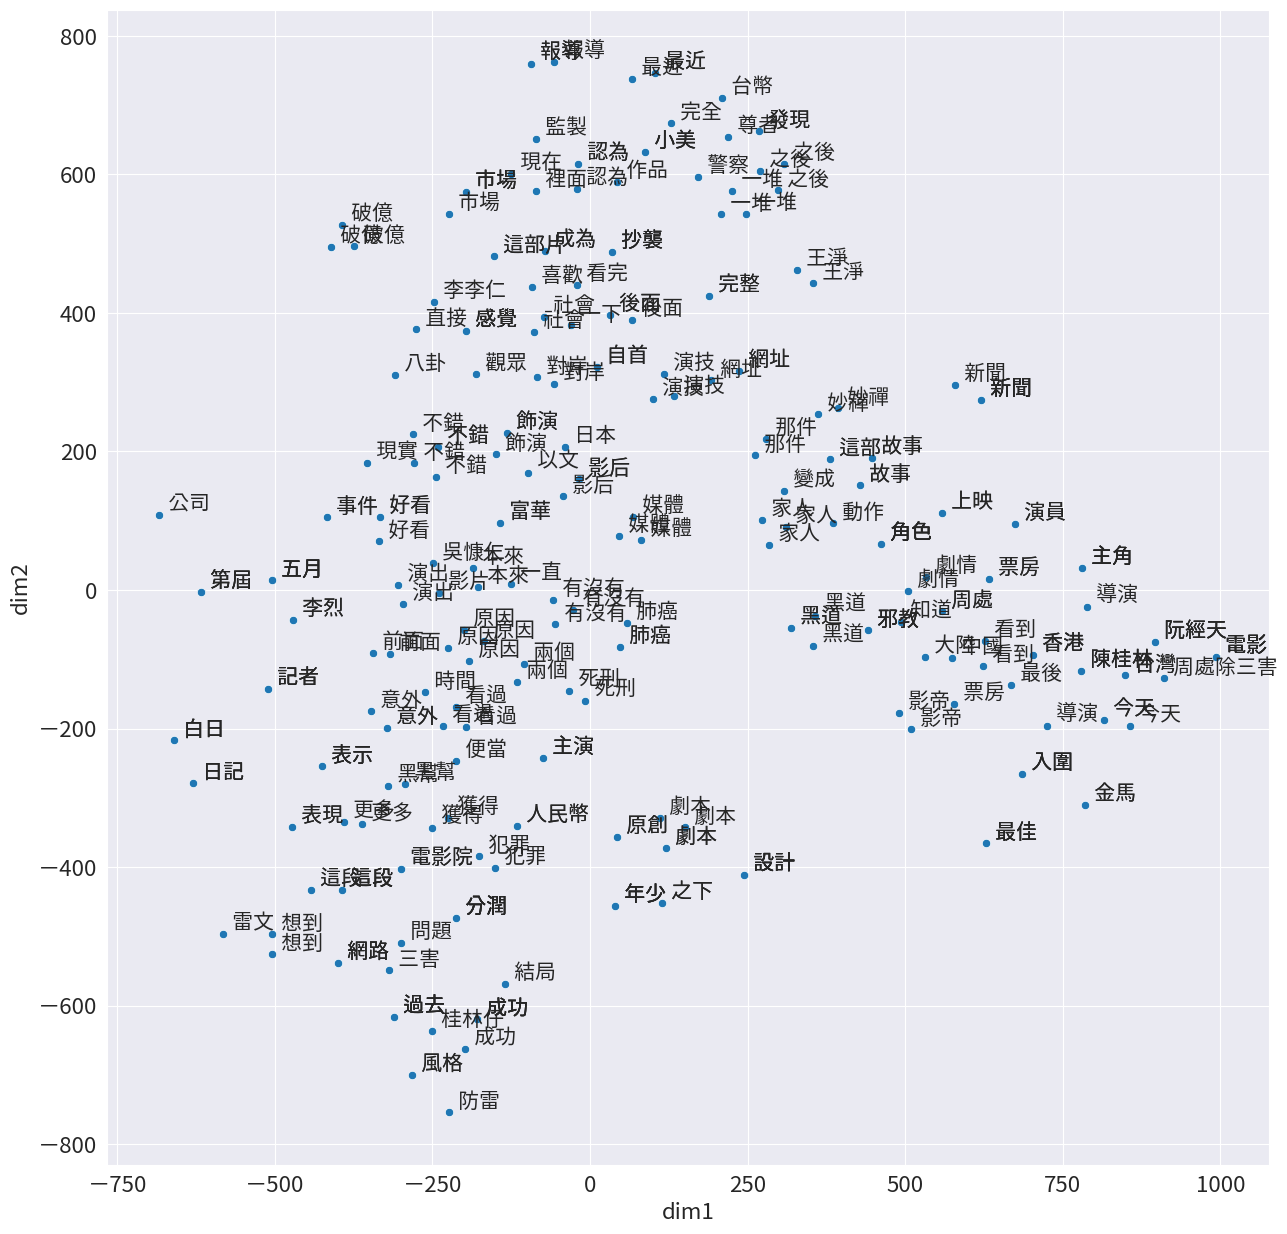

In [ ]:
plotScatter(word_df)

3D 散狀圖

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


將字分群

In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



*   可以看到《白日之下》《年少日記》原創、劇本等自被劃為一群
*   《周處除三害》、阮經天、陳桂林等跟主角名稱相關的會被分為一群
*   「最佳」這個詞彙則是自己單獨分為一群





（2）如何使用別人訓練好的word2vec模型

In [ ]:
model_tmu = KeyedVectors.load_word2vec_format('./tmunlp_1.6B_WB_50dim_2020v1.bin', unicode_errors='ignore', binary=True)

In [ ]:
model_tmu.most_similar('攝護腺癌',topn=10)

[('卵巢癌', 0.8963572978973389),
 ('睪丸癌', 0.859376072883606),
 ('胰臟癌', 0.8455339670181274),
 ('胃癌', 0.8393912315368652),
 ('鼻咽癌', 0.8378424644470215),
 ('膀胱癌', 0.8268745541572571),
 ('肝癌', 0.8243446946144104),
 ('腸癌', 0.8243035674095154),
 ('肺腺癌', 0.8129692077636719),
 ('大腸癌', 0.809378981590271)]

In [ ]:
model_tmu.most_similar('治療',topn=10)

[('化療', 0.8583493232727051),
 ('手術', 0.8439933061599731),
 ('注射', 0.7947844862937927),
 ('放療', 0.7855066061019897),
 ('診療', 0.7805586457252502),
 ('醫治', 0.7794436812400818),
 ('診斷', 0.769790530204773),
 ('麻醉', 0.7673399448394775),
 ('療法', 0.7662969827651978),
 ('診治', 0.7653381824493408)]

In [ ]:
model_tmu.most_similar(positive=['攝護腺癌','治療'],topn=10)

[('卵巢癌', 0.8358115553855896),
 ('肝癌', 0.8331664204597473),
 ('鼻咽癌', 0.8274949789047241),
 ('肺腺癌', 0.820932149887085),
 ('大腸癌', 0.8188324570655823),
 ('腦瘤', 0.8138846158981323),
 ('化療', 0.7920950651168823),
 ('胃癌', 0.7910186648368835),
 ('乳癌', 0.7883343696594238),
 ('肺癌', 0.7836058735847473)]

Transformers Embeddings

使用 Sentence-Transformer 套件

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, models, util

小模型，以BERT為範例

以針對英文、中文以及多語言進行訓練的三種BERT模型做範例。

In [ ]:
# 英文 bert-base-uncased
bert_en = SentenceTransformer('google-bert/bert-base-uncased')

bert_en.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [ ]:
bert_en.get_max_seq_length()

512

In [ ]:
example_text = "This framework generates embeddings for each input sentence"
example_embeddings = bert_en.encode(example_text)

print(example_embeddings.shape)
print("=======================")
print(example_embeddings)

(768,)
[-1.25634462e-01 -2.35391092e-02  9.72141027e-02 -2.14602157e-01
 -4.24758270e-02 -7.68921711e-03  1.66508421e-01  2.09751859e-01
  1.94057614e-01 -9.31545645e-02 -1.04050986e-01 -1.99633911e-01
 -3.48384023e-01  8.10465962e-02 -1.62070300e-02  1.90525740e-01
  5.29038080e-04  1.45439178e-01 -5.54174185e-04 -1.58491224e-01
  1.94275126e-01  1.59165546e-01 -5.99901617e-01  2.65522182e-01
  7.47946143e-01 -2.46598176e-03  1.04436830e-01  1.66958258e-01
 -3.53779316e-01  1.39418587e-01  3.89939174e-02  6.57110155e-01
 -6.23243954e-03 -2.85024077e-01 -1.56140909e-01  8.45852420e-02
  1.65655389e-01 -2.55370468e-01 -1.16442680e-01  9.59284604e-02
 -6.72327161e-01 -3.47994626e-01  8.42593163e-02 -2.06027582e-01
 -5.32231145e-02 -4.90706772e-01 -9.41146351e-03 -3.81041318e-01
  5.67956120e-02 -6.35588408e-01 -1.04700696e+00  3.73333335e-01
  1.31077379e-01  3.08176935e-01 -2.27984279e-01  8.04124415e-01
  1.21666342e-01 -7.21640289e-01  3.69302124e-01 -1.17349744e-01
  1.25593245e-01 -

In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_en = bert_en.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_en, embeddings_en)

# 印出句子間的cosine similarity分數
result = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
result_df.sort_values("score", ascending = False)

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.880907
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.499376
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.480858


In [ ]:
# 回傳cosine similarity分數
def get_result_df(sentences, cosine_scores):

  result = []
  for i in range(len(sentences)):
      for j in range(i+1, len(sentences)):
          result.append([sentences[i], sentences[j], cosine_scores[i][j].item()])

  result_df = pd.DataFrame(result, columns=["sentence1", "sentence2", "score"])
  result_df = result_df.sort_values("score", ascending = False)

  return result_df

中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [ ]:
# 示範句子
sentences = [
    "今天天氣很差。",
    "今天是個大雨滂礡的壞天氣。",
    "我晚上想去KTV唱就讓大雨落下。"
]

# 使用 encode() 對資料做embedding
embeddings_ch = bert_ch.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_ch, embeddings_ch)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
0,今天天氣很差。,今天是個大雨滂礡的壞天氣。,0.888899
2,今天是個大雨滂礡的壞天氣。,我晚上想去KTV唱就讓大雨落下。,0.801830
1,今天天氣很差。,我晚上想去KTV唱就讓大雨落下。,0.795644


多語言 bert-base-multilingual-cased

In [ ]:
# 多語言 bert-base-multilingual-cased
bert_multi = SentenceTransformer('google-bert/bert-base-multilingual-cased')

bert_multi.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

0

In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "敏捷的小胖子優雅地跳過了火燙的火圈。"
]

# 使用 encode() 對資料做embedding
embeddings_multi = bert_multi.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_multi, embeddings_multi)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,敏捷的小胖子優雅地跳過了火燙的火圈。,0.561093
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.350700
1,This framework generates embeddings for each i...,敏捷的小胖子優雅地跳過了火燙的火圈。,0.345911


大模型範例

In [ ]:
!pip install tiktoken
!pip install utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=1ea04aa8e896d8a6597b4ecc302d707f816c6d88f459b48dc5d33d9a6d7f6834
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


Cohere

In [ ]:
!pip install cohere

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


(2) Open Source LLM

LLaMA2

In [ ]:
from huggingface_hub import notebook_login
notebook_login() # 輸入Hugging Face 帳號的Token

In [ ]:
#確認安裝所需套件
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git

#LlamaTokenizer requires the SentencePiece library
!pip install sentencepiece


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer


In [ ]:
model_llama = SentenceTransformer('meta-llama/Llama-2-7b-hf')

model_llama.tokenizer.pad_token = model_llama.tokenizer.eos_token

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer, util
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence.",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy white fox leaps across the dog."
]

# 使用 encode() 對資料做embedding
embeddings_llama = model_llama.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_llama, embeddings_llama)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy white fox leaps across the dog.,0.564812
1,This framework generates embeddings for each i...,The speedy white fox leaps across the dog.,0.515457
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.391589


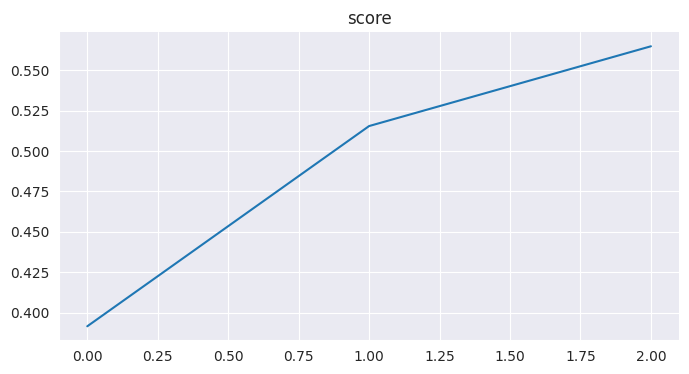

In [ ]:
# @title score

from matplotlib import pyplot as plt
result_df['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

Phi-2

In [ ]:
model_phi2 = SentenceTransformer('microsoft/phi-2')

model_phi2.tokenizer.pad_token = model_phi2.tokenizer.eos_token
# embeddings = model_phi2.encode(['This is example of using phi2'])

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# 示範句子
sentences = [
    "This framework generates embeddings for each input sentence",
    "The quick brown fox jumps over the lazy dog.",
    "The speedy black dog leaps across the cat."
]

# 使用 encode() 對資料做embedding
embeddings_phi2 = model_phi2.encode(sentences)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings_phi2, embeddings_phi2)

# 印出句子間的cosine similarity分數
result_df = get_result_df(sentences, cosine_scores)
result_df

,sentence1,sentence2,score
2,The quick brown fox jumps over the lazy dog.,The speedy black dog leaps across the cat.,0.828458
1,This framework generates embeddings for each i...,The speedy black dog leaps across the cat.,0.745847
0,This framework generates embeddings for each i...,The quick brown fox jumps over the lazy dog.,0.691690


使用embedding做NLP任務

相似文件

In [ ]:
df_similar = movie[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)))

df_similar.head(5)

<ipython-input-34-61f40f0dbbfa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '', str(x)))


,system_id,artTitle,artContent
0,1,[問卦]今年是國片元年嗎？,昨天去看我們金馬男神阮經天演的電影開播前照慣例都會放過幾天要上映的預告片之前加減都會放些國外...
1,2,[問卦]許光漢有機會成為台灣最帥金馬影帝嗎,今年金馬獎最佳男主角競爭激烈台北電影節最佳男主角疫起王柏傑金馬獎影帝周處除三害阮經天新生代男...
2,3,[問卦]租房子有什麼要注意的嗎？,如題啦最近聽朋友在那邊聊金馬入圍名單聊一聊就聽到他們在說租屋的事什麼租房子要除三害之類的到底...
3,4,[問卦]周處除三害是哪三害？☺,是這樣的啦軟今天演出周處除三害三害是大白虎大蛟龍還有一害是什麼不是都說周處除三害嗎
4,5,[問卦]解放軍代言人可以回台爭影帝？,今天周處除三害上映最近也一堆金馬入圍新聞但有人知道阮經天之前是如何嗎用台灣健保在台灣長大演艋...


In [ ]:
from sentence_transformers import SentenceTransformer

# 選擇並加載模型
model = SentenceTransformer('bert-base-chinese')

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

In [ ]:
corpus_embeddings =model.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = model.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [問卦]大膽預測周處除三害會破億

 資料集中前五相似的文章:
[問卦]大膽預測周處除三害會破億 (Score: 1.0000)
[討論]周處除三害該不會在台灣電影院再上映吧？ (Score: 0.9473)
Re:[問卦]周處除三害台灣票房怎麼這麼淒慘？ (Score: 0.9428)
[討論]周處除三害得到上海票房日冠軍 (Score: 0.9345)
[選片]老狐狸or夢行者保羅 (Score: 0.9336)






In [ ]:
query_num = 30

query_embedding = model.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[新聞]阮經天「周處除三害」大陸上映2天票房

 資料集中前五相似的文章:
Re:[新聞]阮經天「周處除三害」大陸上映2天票房 (Score: 1.0000)
Re:[問卦]周處除三害台灣票房怎麼這麼淒慘？ (Score: 0.9558)
[問卦]為啥周處除三害靈院有些人不走? (Score: 0.9557)
[問卦]周處除三害是不是國片黑道電影的新風貌？ (Score: 0.9551)
[問卦]周處就在殺邪教，台灣為什麼會有人反彈 (Score: 0.9544)




